In [1]:
import sys
sys.path.append('../code/')

In [2]:
%load_ext autoreload
%autoreload 2

from libs import io
from libs import constants
from libs import vis
from libs import helpers
from postprocessing import consistency as cons

# Setup

In [3]:
VALID_RESPONSES_PATH = '../results/valid_responses'
PLOTS_PATH = '../results/plots'

In [4]:
vis.sns_reset()
vis.sns_paper_style()

## Data

In [5]:
df_valid_responses = io.pd.concat([io.read_csv(io.path_join(VALID_RESPONSES_PATH, f"{model}.csv"), index_col=0) for model in constants.LLMS], ignore_index=True)
df_valid_responses['task_name'] = io.pd.Categorical(df_valid_responses['task_name'], categories=constants.EXPERIMENT_TASKS, ordered=True)
df_valid_responses.shape


(138439, 14)

In [6]:
df_valid_responses.head(2)

,date,time,llm_model,task_name,task_param,task_attempt,result_valid_flag,name,years,doi,career_age,clean_name,model,valid_attempt
0,2024-12-09,00:00,llama3-8b-8192,epoch,1950s,1,valid,Richard Feynman,1950-1960,NaN,NaN,richard feynman,llama3-8b,True
1,2024-12-09,00:00,llama3-8b-8192,epoch,1950s,1,valid,Julian Schwinger,1950-1960,NaN,NaN,julian schwinger,llama3-8b,True


# Consistency
Similarity of results

In [7]:
df_consistency = cons.run_consistency_jaccard_similarity(df_valid_responses)
df_consistency['task_name'] = io.pd.Categorical(df_consistency['task_name'], categories=constants.EXPERIMENT_TASKS, ordered=True)
df_consistency = df_consistency.groupby(['model','task_name']).average_jaccard_similarity.agg(['mean','std']).reset_index()
df_consistency.fillna({'std':0}, inplace=True)

Processing Groups:  10%|█         | 9/87 [00:00<00:00, 84.81it/s]/Users/espinl/anaconda3/envs/py311LLMEval/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/espinl/anaconda3/envs/py311LLMEval/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Processing Groups: 100%|██████████| 87/87 [00:00<00:00, 149.97it/s]
/var/folders/lj/_xkc5wfx66n7wxk15hc05rjm0000gn/T/ipykernel_95581/2899182945.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_consistency = df_consistency.groupby(['model','task_name']).average_jaccard_similarity.agg(['mean','std']).reset_index()


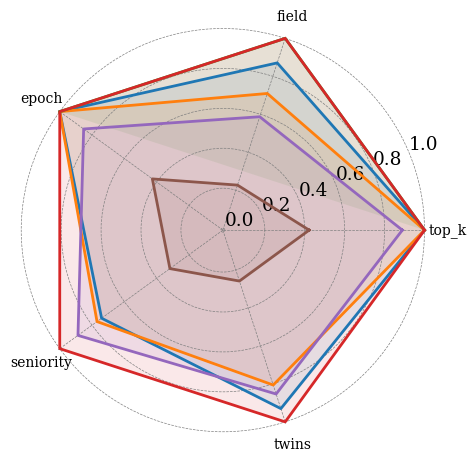

In [8]:
fname = 'consistency_jaccard.pdf'
fn = io.path_join(PLOTS_PATH, fname)

hue = 'model'
x_col = 'task_name'
x_order = constants.EXPERIMENT_TASKS
mean_col = 'mean'
std_col = 'std'
hue_order = constants.LLMS
hue_colors = constants.LLMS_COLORS

vis.plot_spiderweb(df_consistency, x_col=x_col, x_order=x_order, y_col=mean_col,
                   hue=hue, hue_order=hue_order, hue_colors=hue_colors,
                   ylim=constants.PLOT_YLIM_SPIDER_PCT, 
                   fn=fn,
                   legend_kwargs = constants.PLOT_LEGEND_KWARGS_SPIDER,
                   figsize=constants.PLOT_FIGSIZE_SPIDER)

/Users/espinl/Documents/CODE/LLM-project/LLMScholar-WWW24/Auditor/notebooks/../code/libs/helpers.py:34: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tmp = df.pivot_table(index=index_col, columns=columns_col, values=values_col).T.reset_index()
/Users/espinl/Documents/CODE/LLM-project/LLMScholar-WWW24/Auditor/notebooks/../code/libs/helpers.py:34: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tmp = df.pivot_table(index=index_col, columns=columns_col, values=values_col).T.reset_index()
/Users/espinl/Documents/CODE/LLM-project/LLMScholar-WWW24/Auditor/notebooks/../code/libs/vis.py:303: FutureWarning: The default of observed=False is deprecated and will be changed to T

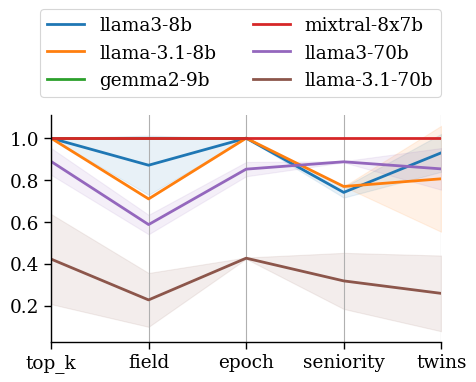

In [9]:
fn = io.path_join(PLOTS_PATH, fname.replace('.pdf','_parallel_coords.pdf'))

df_consistency_mean_t = helpers.pivot_model_tasks(df_consistency, index_col=x_col, columns_col=hue, values_col=mean_col, x_order=x_order, hue_order=hue_order)
df_consistency_std_t = helpers.pivot_model_tasks(df_consistency, index_col=x_col, columns_col=hue, values_col=std_col, x_order=x_order, hue_order=hue_order)
vis.plot_parallel_coords(df_consistency_mean_t, hue=hue, hue_order=hue_order, hue_colors=hue_colors,
                         df_err=df_consistency_std_t, 
                         legend_kwargs = constants.PLOT_LEGEND_KWARGS_PARALLEL_COORD,
                         figsize=constants.PLOT_FIGSIZE,
                         fn=fn)

# Duplicates

In [10]:
df_duplicates = cons.run_consistency_uniqueness(df_valid_responses)
df_duplicates['task_name'] = io.pd.Categorical(df_duplicates['task_name'], categories=constants.EXPERIMENT_TASKS, ordered=True)
df_duplicates = df_duplicates.groupby(['model','task_name']).duplicates_pct.agg(['mean','std']).reset_index()
df_duplicates.head(2)

/var/folders/lj/_xkc5wfx66n7wxk15hc05rjm0000gn/T/ipykernel_95581/1556376572.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_duplicates = df_duplicates.groupby(['model','task_name']).duplicates_pct.agg(['mean','std']).reset_index()


,model,task_name,mean,std
0,gemma2-9b,top_k,0.0,0.0
1,gemma2-9b,field,0.0,0.0


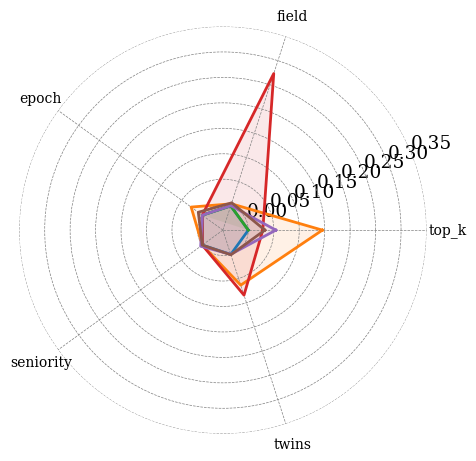

In [11]:
fname = 'consistency_duplicates.pdf'
fn = io.path_join(PLOTS_PATH, fname)

hue = 'model'
x_col = 'task_name'
x_order = constants.EXPERIMENT_TASKS
mean_col = 'mean'
std_col = 'std'
hue_order = constants.LLMS
hue_colors = constants.LLMS_COLORS

vis.plot_spiderweb(df_duplicates, x_col=x_col, x_order=x_order, y_col=mean_col,
                   hue=hue, hue_order=hue_order, hue_colors=hue_colors,
                   ylim=(-0.05,0.35), ytickval=0.5,
                   fn=fn,
                   legend_kwargs = {'title':'', 'loc': 'lower left', 'ncols':2, 'bbox_to_anchor':(-0.04,1.02,1,0.2)},
                   figsize=constants.PLOT_FIGSIZE_SPIDER)

/Users/espinl/Documents/CODE/LLM-project/LLMScholar-WWW24/Auditor/notebooks/../code/libs/helpers.py:34: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tmp = df.pivot_table(index=index_col, columns=columns_col, values=values_col).T.reset_index()
/Users/espinl/Documents/CODE/LLM-project/LLMScholar-WWW24/Auditor/notebooks/../code/libs/helpers.py:34: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tmp = df.pivot_table(index=index_col, columns=columns_col, values=values_col).T.reset_index()
/Users/espinl/Documents/CODE/LLM-project/LLMScholar-WWW24/Auditor/notebooks/../code/libs/vis.py:303: FutureWarning: The default of observed=False is deprecated and will be changed to T

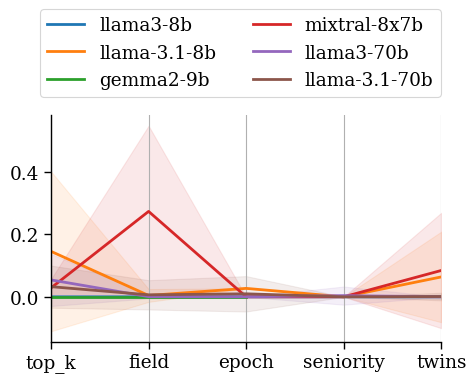

In [12]:
fn = io.path_join(PLOTS_PATH, fname.replace('.pdf','_parallel_coords.pdf'))

df_duplicates_mean_t = helpers.pivot_model_tasks(df_duplicates, index_col=x_col, columns_col=hue, values_col=mean_col, x_order=x_order, hue_order=hue_order)
df_duplicates_std_t = helpers.pivot_model_tasks(df_duplicates, index_col=x_col, columns_col=hue, values_col=std_col, x_order=x_order, hue_order=hue_order)
vis.plot_parallel_coords(df_duplicates_mean_t, hue=hue, hue_order=hue_order, hue_colors=hue_colors,
                         df_err=df_duplicates_std_t, 
                         legend_kwargs = constants.PLOT_LEGEND_KWARGS_PARALLEL_COORD,
                         figsize=constants.PLOT_FIGSIZE,
                         fn=fn)